In [1]:
from __future__ import absolute_import, division, print_function
import sys
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
imageio.plugins.ffmpeg.download()
print(f'Running on Tensorflow {tf.__version__} and Python {sys.version}')

Imageio: 'ffmpeg-win32-v3.2.4.exe' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-win32-v3.2.4.exe (34.1 MB)
Downloading: 8192/35749888 bytes (0.0%)65536/35749888 bytes (0.2%)122880/35749888 bytes (0.3%)180224/35749888 bytes (0.5%)237568/35749888 bytes (0.7%)294912/35749888 bytes (0.8%)352256/35749888 bytes (1.0%)409600/35749888 bytes (1.1%)466944/35749888 bytes (1.3%)524288/35749888 bytes (1.5%)581632/35749888 bytes (1.6%)638976/35749888 bytes (1.8%)696320/35749888 bytes (1.9%)753664/35749888 bytes (2.1%)81100

C:\Users\alien\AppData\Roaming\Python\Python38\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 无法在设置线程模式后对其加以更改。
  warnings.warn(str(err))


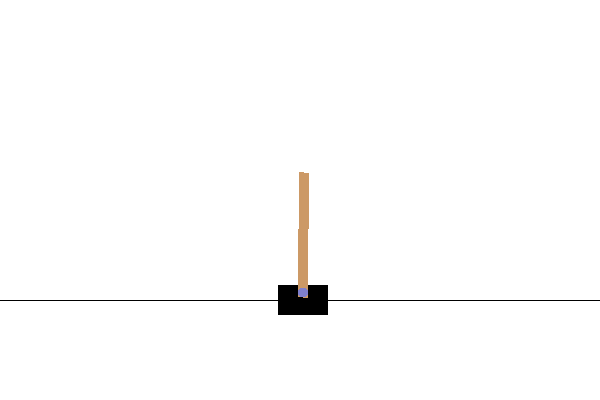

In [2]:
num_iterations = 20000
initial_collect_steps = 100
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000
batch_size = 64
learning_rate = 1e-3
log_interval = 200
num_eval_episodes = 10
eval_interval = 1000
dense_layer_params = (100,50)  # no of units for layers. Add more numbers to increase no of layers

env_name = 'CartPole-v0'
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In [3]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Reward Spec:')
print(env.time_step_spec().reward)
print('Action Spec:')
print(env.action_spec())
time_step = env.reset()
print('Time step:')
print(time_step)
action = np.array(1, dtype=np.int32)  # 0 - left, 1 - right
next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)
Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([0.02083339, 0.03556455, 0.045459  , 0.02713781], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.02154468,  0.2300061 ,  0.04600175, -0.25086287], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1)})


In [4]:
# Two env are made, one for training one for val
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)
# Convert them to tensorflow env to run faster
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [5]:
# DQN Agent: Q-Network
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right activation and kernel initializer.
def dense_layer(num_units):
  return Dense(num_units, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer with `num_actions` units to generate one q_value per available action as it's output.
dense_layers = [dense_layer(num_units) for num_units in dense_layer_params]
q_values_layer = Dense(num_actions, activation=None, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03),
                       bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=opt,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [6]:
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [7]:
print(agent.collect_data_spec)
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# steps=2 here as we need both the current and future observation of the env to calculate loss
dataset = replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())  # random movements
print('Baseline result using random movements:')
compute_avg_return(eval_env, random_policy, num_eval_episodes)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)
iterator = iter(dataset)
print(iterator.next())

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0, dtype=int64), maximum=array(1, dtype=int64)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Baseline result using random movements:
(Trajectory(
{'action': <tf.Tensor: shape=(64, 2), dtype=int64,

In [8]:
agent.train = common.function(agent.train)  # Optimize by wrapping some of the code in a graph using TF function.
agent.train_step_counter.assign(0)  # Reset the train step

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):
  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, extra_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print(f'step = {step}: loss = {train_loss}')

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print(f'step = {step}: Average Return = {avg_return}')
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 13.853405952453613
step = 400: loss = 4.832927703857422
step = 600: loss = 8.353018760681152
step = 800: loss = 7.465332984924316
step = 1000: loss = 22.840007781982422
step = 1000: Average Return = 17.200000762939453
step = 1200: loss = 461.08843994140625
step = 1400: loss = 350.168701171875
step = 1600: loss = 58.996910095214844
step = 1800: loss = 2126.880859375
step = 2000: loss = 2079.32421875
step = 2000: Average Return = 200.0
step = 2200: loss = 1381.35498046875
step = 2400: loss = 1671.0660400390625
step = 2600: loss = 1921.6082763671875
step = 2800: loss = 67493.15625
step = 3000: loss = 32728.970703125
step = 3000: Average Return = 200.0
step = 3200: loss = 5354.3447265625
step = 3400: loss = 5600.638671875
step = 3600: loss =

(1.8650002002716057, 250.0)

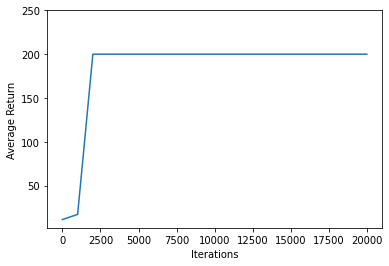

In [9]:
# Visualise reward, max 200 for CartPole-v0
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [10]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=10, fps=60):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

# Generate results videos of trained and random
create_policy_eval_video(agent.policy, "trained-agent")
create_policy_eval_video(random_policy, "random-agent")